<a href="https://colab.research.google.com/github/waltermaffy/gan_thesis/blob/master/WGAN_GP_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASSERSTEIN GAN with GRADIENT PENALTY
code partially taken from https://github.com/EmilienDupont/wgan-gp

In [0]:
import imageio
import numpy as np
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.utils as vutils
import time
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path

# PARAMETERS

In [0]:
batch_size = 128
img_size = (32, 32, 1)
dataset_name = 'FASHION'  # Possible datasets [MNIST, FASHION, LSUN]
lr = 2e-4
betas = (.5, .99)
epochs = 200
ngpu = 1
weights_backup = True #Save weights during training
weights_restore = True #Set to False if want to restart training from zero

In [3]:
if weights_backup: 
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TESI/TESI GAN Maffione/Colab/DCGAN basic/WGAN-GP/'
  image_path = path + 'wganGP_' + dataset_name 
  checkpoint_file = path + 'wganGP_' + dataset_name + '_checkpoint.pt'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# DATA LOADER

0it [00:00, ?it/s]

26427392it [00:01, 13813703.79it/s]                             


Extracting ../fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../fashion_data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 98650.33it/s]                            
0it [00:00, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../fashion_data/FashionMNIST/raw


4423680it [00:01, 4067425.00it/s]                             
0it [00:00, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../fashion_data/FashionMNIST/raw


8192it [00:00, 33950.73it/s]            


Extracting ../fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../fashion_data/FashionMNIST/raw
Processing...
Done!
Dataset FASHION contains 60000 images


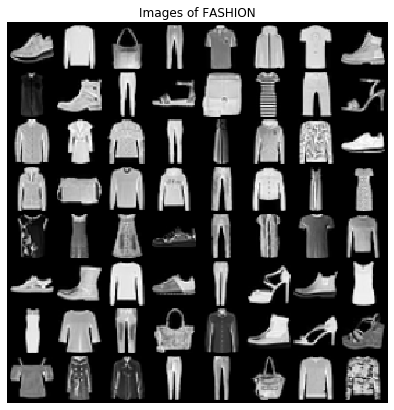

In [4]:
def get_mnist_dataloaders(batch_size=128):
    """MNIST dataloader with (32, 32) sized images."""
    # Resize images so they are a power of 2
    all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    # Get train and test data
    train_data = datasets.MNIST('../data', train=True, download=True,
                                transform=all_transforms)
    test_data = datasets.MNIST('../data', train=False,
                               transform=all_transforms)
    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader


def get_fashion_mnist_dataloaders(batch_size=128):
    """Fashion MNIST dataloader with (32, 32) sized images."""
    # Resize images so they are a power of 2
    all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
    # Get train and test data
    train_data = datasets.FashionMNIST('../fashion_data', train=True, download=True,
                                       transform=all_transforms)
    test_data = datasets.FashionMNIST('../fashion_data', train=False,
                                      transform=all_transforms)
    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader


def get_lsun_dataloader(path_to_data='../lsun', dataset='bedroom_train',
                        batch_size=64):
    """LSUN dataloader with (128, 128) sized images.
    path_to_data : str
        One of 'bedroom_val' or 'bedroom_train'
    """
    # Compose transforms
    transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor()
    ])

    # Get dataset
    lsun_dset = datasets.LSUN(db_path=path_to_data, classes=[dataset],
                              transform=transform)

    # Create dataloader
    return DataLoader(lsun_dset, batch_size=batch_size, shuffle=True)

if dataset_name == 'MNIST':
  data_loader, _ = get_mnist_dataloaders(batch_size=batch_size)
elif dataset_name == 'FASHION':
  data_loader, _ = get_fashion_mnist_dataloaders(batch_size=batch_size)
elif dataset_name == 'LSUN':
  data_loader, _ = get_lsun_dataloader(batch_size=batch_size)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some images
real_batch = next(iter(data_loader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Images of {}".format(dataset_name))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

print('Dataset {} contains {} images'.format(dataset_name, len(data_loader.dataset)))

# MODELS

In [5]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (int(self.img_size[0] / 16), int(self.img_size[1] / 16))

        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * self.feature_sizes[0] * self.feature_sizes[1]),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 8 * self.dim, self.feature_sizes[0], self.feature_sizes[1])
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))


class Discriminator(nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Discriminator, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            nn.Sigmoid()
        )

        # 4 convolutions of stride 2, i.e. halving of size everytime
        # So output size will be 8 * (img_size / 2 ^ 4) * (img_size / 2 ^ 4)
        output_size = 8 * dim * (int(img_size[0] / 16)) * (int(img_size[1] / 16))
        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.image_to_features(input_data)
        x = x.view(batch_size, -1)
        return self.features_to_prob(x)


#define models
generator = Generator(img_size=img_size, latent_dim=100, dim=16)
discriminator = Discriminator(img_size=img_size, dim=16)

print(generator)
print(discriminator)

Generator(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)
Discriminator(
  (image_to_features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0

# TRAINER

In [0]:
class Trainer():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=499,
                 use_cuda=False):
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.start_epoch = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data):
        """ """
        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate probabilities on real and generated data
        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        d_real = self.D(data)
        d_generated = self.D(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()

        self.D_opt.step()

        # Record loss
        self.losses['D'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        """ """
        self.G_opt.zero_grad()

        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate loss and optimize
        d_generated = self.D(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.G_opt.step()

        # Record loss
        self.losses['G'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader,epoch):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data[0])
            # Only update generator every |critic_iterations| iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data[0])

            if i % self.print_every == 0 and self.num_steps > self.critic_iterations:
                print("[%d/%d]\tD_loss: %.2f,\tG_loss: %.2f,\t[GP: %.2f, Gradient norm: %.2f]" % (epoch, epochs, self.losses['D'][-1], self.losses['G'][-1], self.losses['GP'][-1], self.losses['gradient_norm'][-1] ) )
    
    def train(self, data_loader, epochs, show_results=True):
        if show_results:
            # Fix latents to see how image generation improves during training
            fixed_latents = Variable(self.G.sample_latent(64))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()
            training_progress_images = []
        
        if weights_restore and Path(checkpoint_file).exists():
          self.restore_checkpoint(checkpoint_file)
          print('Checkpoint found and restored at epoch {}'.format(self.start_epoch))
        else: 
          print('Checkpoint not used or not exist\n')

        print('###########   START TRAINING   ############')
        start = time.time()

        for epoch in range(epochs-self.start_epoch):
            epoch+=self.start_epoch

            self._train_epoch(data_loader, epoch)

            if show_results:
                # Generate batch of images and convert to grid
                img_grid = make_grid(self.G(fixed_latents).cpu().data)
                # Convert to numpy and transpose axes to fit imageio convention i.e. (width, height, channels)
                img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
                # Add image grid to training progress
                training_progress_images.append(img_grid)

            if epoch % 10 == 0:
                self.plot_epoch(epoch, img_grid)

            if weights_backup and epoch % 20 == 0:
                self.store_checkpoint(epoch, checkpoint_file)

        end = time.time()
        print('Total training time: {} min, {} sec '.format(int((end - start) / 60), int((end - start) % 60)))

        if show_results:
            self.plot_save_generated(epoch, save=True)

    def sample_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

    def plot_epoch(self, epoch, img_grid):
        plt.figure(figsize=(7,7))
        plt.imshow(img_grid)
        plt.axis('off')
        plt.title('Generated images after epoch {}'.format(epoch))
        plt.show()

    def plot_save_generated(self, epoch=epochs, save=False):
        latents = Variable(self.G.sample_latent(64)).cuda()
        img = make_grid(self.G(latents).cpu().data)
        img = np.transpose(img.numpy(), (1, 2, 0))
        plt.figure(figsize=(7,7))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Generated images after {} epochs'.format(epoch))
        plt.show()
        if save:
          plt.savefig(image_path + '_generated_%d.png' % epoch)
          plt.close()

    def plot_genererated(self, r=3,c=3):
        gen_imgs = self.sample(r*c)
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

    def store_checkpoint(self, epoch, checkpoint_file):
      torch.save({'epoch': epoch,
                  'generator': self.G.state_dict(),
                  'discriminator': self.D.state_dict(),
                  'optimizerG': self.G_opt.state_dict(),
                  'optimizerD': self.D_opt.state_dict(),
                  'loss': self.losses
                  #'GP': self.gp_weight.state_dict()
                  }, checkpoint_file)
        
      print('Saved checkpoint at epoch: ', epoch)

    def restore_checkpoint(self,checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        self.G.load_state_dict(checkpoint['generator'])
        self.D.load_state_dict(checkpoint['discriminator'])
        self.G_opt.load_state_dict(checkpoint['optimizerG'])
        self.D_opt.load_state_dict(checkpoint['optimizerD'])
        #self.gp_weight.load_state_dict(checkpoint['GP'])
        self.losses = checkpoint['loss']
        self.start_epoch = checkpoint['epoch']
        
    def plot_and_save_losses(self):
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Losses During Training")
        plt.plot(self.losses['G'],label="G")
        plt.plot(self.losses['D'],label="D")
        plt.plot(self.losses['GP'],label="GP")
        plt.plot(self.losses['gradient_norm'],label="gradien_norm")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(image_path + 'losses.png')
        plt.show()


# MAIN 

Checkpoint found and restored at epoch 180
###########   START TRAINING   ############


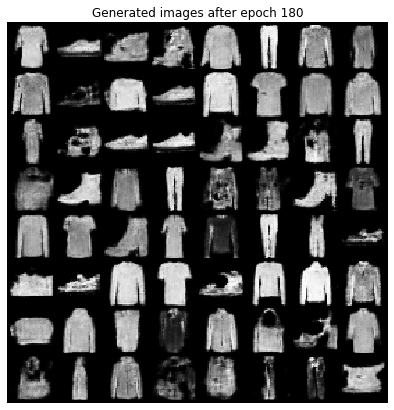

Saved checkpoint at epoch:  180
[181/200]	D_loss: -0.28,	G_loss: -0.42,	[GP: 0.02, Gradient norm: 1.00]
[182/200]	D_loss: -0.23,	G_loss: -0.42,	[GP: 0.06, Gradient norm: 1.00]
[183/200]	D_loss: -0.22,	G_loss: -0.38,	[GP: 0.07, Gradient norm: 0.99]
[184/200]	D_loss: -0.12,	G_loss: -0.34,	[GP: 0.10, Gradient norm: 0.96]
[185/200]	D_loss: -0.20,	G_loss: -0.36,	[GP: 0.05, Gradient norm: 0.98]
[186/200]	D_loss: -0.17,	G_loss: -0.41,	[GP: 0.07, Gradient norm: 1.03]
[187/200]	D_loss: -0.25,	G_loss: -0.33,	[GP: 0.04, Gradient norm: 0.99]
[188/200]	D_loss: -0.22,	G_loss: -0.44,	[GP: 0.03, Gradient norm: 1.00]
[189/200]	D_loss: -0.22,	G_loss: -0.38,	[GP: 0.09, Gradient norm: 0.99]


In [0]:
# Initialize optimizers
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Train model
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer, use_cuda=torch.cuda.is_available())
trainer.train(data_loader, epochs, show_results=True)

#Plot and save images
#trainer.plot_genererated(4,4)
trainer.plot_save_generated()
trainer.plot_and_save_losses()

In [0]:
trainer.plot_save_generated()